In [1]:
!pip install librosa soundfile --quiet

In [2]:
# Libs for loading the data
import os
import pandas as pd
import numpy as np
import kagglehub
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import soundfile as sf
from collections import Counter
from random import sample

In [3]:
!gdown --id 1VFOheZrF15sabi9JLV7NrOrOVGJFfHIX

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1VFOheZrF15sabi9JLV7NrOrOVGJFfHIX
From (redirected): https://drive.google.com/uc?id=1VFOheZrF15sabi9JLV7NrOrOVGJFfHIX&confirm=t&uuid=76208606-9c18-4d79-910b-7e5acb9345fa
To: /kaggle/working/project_data.zip
100%|███████████████████████████████████████| 1.35G/1.35G [00:12<00:00, 104MB/s]


In [4]:
!unzip -o -q "/kaggle/working/project_data.zip" -d "/kaggle/working"

In [5]:
base_dir = '/kaggle/working/project_data'
img_dir = '/kaggle/input/img_arrs'
audio_dir = '/kaggle/working/project_data/music'
batch_size = 256

In [6]:
df_train = pd.read_csv(f"{base_dir}/cleaned_train_matching.txt", sep=' ', header=None, names=["audio_id", "image_file", "score"])
df_val = pd.read_csv(f"{base_dir}/cleaned_val_matching.txt", sep=' ', header=None, names=["audio_id", "image_file", "score"])
df_test = pd.read_csv(f"{base_dir}/cleaned_test_matching.txt", sep=' ', header=None, names=["audio_id", "image_file", "score"])

print(f"Train: {len(df_train)}, Val: {len(df_val)}, Test: {len(df_test)}")

Train: 19566, Val: 1579, Test: 4213


In [7]:
class ImageAudioDataset(Dataset):
    def __init__(self, df, img_dir, audio_dir, sr=44100, max_sec=50):
        """
        sr : int, optional
            Target sampling rate for audio files. All audio will be resampled to this rate. Default is 44100 Hz.
        max_sec : int, optional
            Maximum duration of audio in seconds. Audio will be truncated or zero-padded to exactly `sr * max_sec` samples. Default is 50 seconds.
        """
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.audio_dir = audio_dir
        self.sr = sr
        self.max_len = sr * max_sec  # 50 seconds = 2,205,000 samples
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load image
        img_path = os.path.join(self.img_dir, row["image_file"])
        img = np.load(img_path).astype(np.float32) #/ 255.0
        img = torch.tensor(img).permute(2, 0, 1)  # [H, W, C] → [C, H, W]

        # Load audio
        audio_id = row["audio_id"].split("-")[0]
        audio_path = os.path.join(self.audio_dir, f"{audio_id}.mp3")
        y, _ = librosa.load(audio_path, sr=self.sr)

        # Pad or truncate to exactly 50 seconds
        if len(y) < self.max_len:
            y = np.pad(y, (0, self.max_len - len(y)), mode='constant')
        else:
            # Random crop to augment the audio a little bit
            rand_idx_start = np.random.choice(np.arange(0, len(y) - 1 - self.max_len))
            y = y[rand_idx_start:rand_idx_start + self.max_len]

        audio_tensor = torch.tensor(y, dtype=torch.float32)

        return {
            "image": img,
            "audio_raw": audio_tensor,
            "score": torch.tensor(row["score"]).float(),
            "audio_id": row["audio_id"]
        }


In [8]:
train_loader = DataLoader(ImageAudioDataset(df_train, img_dir, audio_dir), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(ImageAudioDataset(df_val, img_dir, audio_dir), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(ImageAudioDataset(df_test, img_dir, audio_dir), batch_size=batch_size, shuffle=True)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


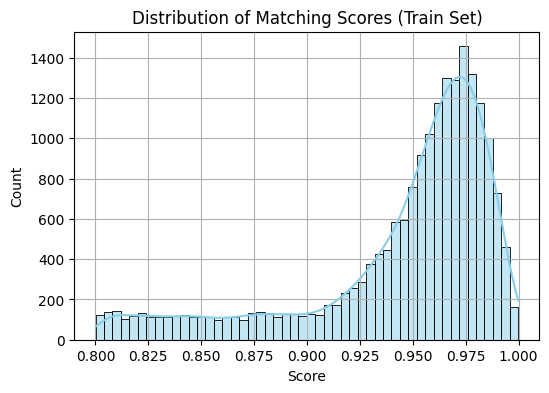

Score stats:
Min: 0.8000566627007694
Max: 0.9998107522735143
Mean: 0.9449


In [9]:
plt.figure(figsize=(6, 4))
sns.histplot(df_train['score'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Matching Scores (Train Set)")
plt.xlabel("Score")
plt.ylabel("Count")
plt.grid(True)
plt.show()

print("Score stats:")
print("Min:", df_train['score'].min())
print("Max:", df_train['score'].max())
print("Mean:", round(df_train['score'].mean(), 4))

In [10]:
for name, df in zip(['train', 'val', 'test'], [df_train, df_val, df_test]):
    missing = sum(not os.path.exists(os.path.join(img_dir, fname)) for fname in df["image_file"])
    print(f"Missing image files in {name} set: {missing} out of {len(df)}")

Missing image files in train set: 0 out of 19566
Missing image files in val set: 0 out of 1579
Missing image files in test set: 0 out of 4213


In [11]:
audio_ids = set(os.path.splitext(f)[0] for f in os.listdir(audio_dir) if f.endswith(".mp3"))

# Get numeric part of audio_id from matching files (e.g. "2009-114" → "2009")
def extract_numeric_audio_id(audio_id):
    return audio_id.split("-")[0]

matching_audio_ids = set(
    extract_numeric_audio_id(aid)
    for aid in pd.concat([df_train, df_val, df_test])["audio_id"]
)

# Compare actual vs expected
missing_mp3s = matching_audio_ids - audio_ids
extra_mp3s = audio_ids - matching_audio_ids

print("Total unique numeric audio_ids in matchings:", len(matching_audio_ids))
print("Total uploaded audio files:", len(audio_ids))
print("Missing audio files:", len(missing_mp3s))
print("Extra audio files (not used):", len(extra_mp3s))
if missing_mp3s:
    print("Example missing:", list(missing_mp3s)[:5])

Total unique numeric audio_ids in matchings: 1800
Total uploaded audio files: 1802
Missing audio files: 0
Extra audio files (not used): 2



Number of sampled audio files: 150

Sampled duration stats:
Avg: 52.68 s
Min: 44.96 s
Max: 303.54 s
Median: 45.03 s


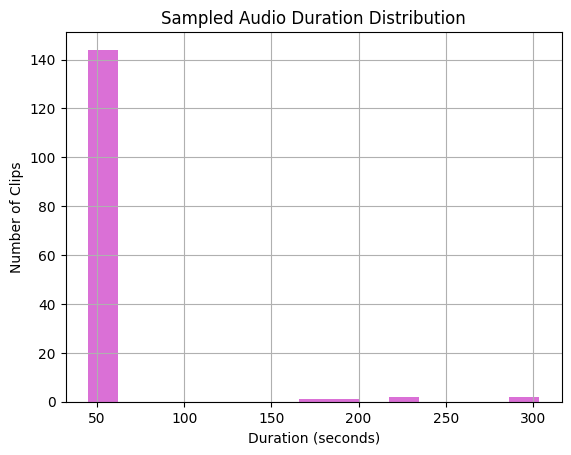

In [12]:
SAMPLE_FILES_LEN = min(150, len(audio_ids))
sampled_ids = sample(list(audio_ids), SAMPLE_FILES_LEN)

print(f"\nNumber of sampled audio files: {len(sampled_ids)}")

durations = []

for aid in sampled_ids:
    path = os.path.join(audio_dir, f"{aid}.mp3")
    try:
        y, sr = librosa.load(path, sr=None)
        durations.append(len(y) / sr)
    except Exception as e:
        print(f"Failed to load {aid}.mp3:", e)

print("\nSampled duration stats:")
print("Avg:", round(np.mean(durations), 2), "s")
print("Min:", round(np.min(durations), 2), "s")
print("Max:", round(np.max(durations), 2), "s")
print("Median:", round(np.median(durations), 2), "s")

plt.hist(durations, bins=15, color='orchid')
plt.title("Sampled Audio Duration Distribution")
plt.xlabel("Duration (seconds)")
plt.ylabel("Number of Clips")
plt.grid(True)
plt.show()

In [13]:
sr_list = []
failures = []

for fname in os.listdir(audio_dir):
    if fname.endswith(".mp3"):
        path = os.path.join(audio_dir, fname)
        try:
            info = sf.SoundFile(path)
            sr_list.append(info.samplerate)
        except Exception as e:
            failures.append(fname)

# Count occurrences of each SR
sr_counter = Counter(sr_list)

# Print summary
print("Sampling Rate Distribution (All Files):")
for rate, count in sr_counter.items():
    print(f"{rate} Hz: {count} files")

print(f"\nTotal analyzed: {len(sr_list)}")
print(f"Failed to read: {len(failures)}")
if failures:
    print("Example failed files:", failures[:5])

Sampling Rate Distribution (All Files):
44100 Hz: 1778 files
48000 Hz: 20 files
22050 Hz: 3 files
16000 Hz: 1 files

Total analyzed: 1802
Failed to read: 0


In [14]:
# Dimensions of batches:
# batch["image"].shape -> [B, 3, 224, 224]
# batch["audio_raw"].shape -> [B, sr * max_sec]
# Optional:
# batch["score"].shape -> [B]
# batch["audio_id"] -> List of IDs

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

***Model***

In [23]:
class PictureToMusicConfig:
    image_encoder_type = 'vit'
    image_encoder_checkpoint = 'google/vit-base-patch16-224-in21k'
    audio_encoder_type = 'clap'
    audio_encoder_checkpoint = 'laion/clap-htsat-unfused'
    freeze_audio_encoder = True
    freeze_image_encoder = False
    num_layers_to_unfreeze = 2
    image_embedding_size = 768
    audio_embedding_size = 512
    shared_embedding_size = 512
    has_audio_mapper = False
    mlp_hidden_size = 1024

In [24]:
from transformers import ViTModel, ViTImageProcessorFast, ClapModel, ClapProcessor
import torch
from torchvision import transforms
from torch import nn

class ImageEncoder(nn.Module):
    def __init__(self, model_type, checkpoint):
        super().__init__()
        self.model_type = model_type

        if self.model_type == 'vit':
            # Load the model and the class that the inputs go through
            self.model = ViTModel.from_pretrained(checkpoint, device_map='auto')
            self.preprocessor = ViTImageProcessorFast.from_pretrained(checkpoint)
        else:
            raise Exception('Unsupported model for image encoder')

    def encode(self, data):
        if self.model_type == 'vit':
            inputs = self.preprocessor(images = data, return_tensors="pt", do_normalize=True, do_convert_rgb=True, do_rescale=True, do_resize=True)
            inputs = inputs.to(device)
            outputs = self.model(**inputs)
            return outputs.pooler_output

class AudioEncoder(nn.Module):
    def __init__(self, model_type, checkpoint):
        super().__init__()
        self.model_type = model_type

        if self.model_type == 'clap':
            # Load the model and the class that the inputs go through
            self.model = ClapModel.from_pretrained(checkpoint, device_map='auto')
            self.preprocessor = ClapProcessor.from_pretrained(checkpoint, use_fast=True)
        else:
            raise Exception('Unsupported model for audio encoder')

    def encode(self, sampling_rate, waveforms):
        if self.model_type == 'clap':
            inputs = self.preprocessor(audios=waveforms.numpy(), sampling_rate=sampling_rate, return_tensors='pt')
            inputs = inputs.to(device)
            outputs = self.model.get_audio_features(**inputs)
            return outputs

class MLPMapper(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.GELU(),
            torch.nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.mlp(x)


2025-06-24 16:16:52.549776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750781812.760180      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750781812.815770      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [25]:
class PictureToMusicModel(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.init_image_encoder()
        self.init_audio_encoder()

        self.image_mapper = MLPMapper(
            input_dim=self.config.image_embedding_size, 
            hidden_dim=self.config.mlp_hidden_size, 
            output_dim=self.config.shared_embedding_size
        )
        if config.has_audio_mapper:
            self.audio_mapper = MLPMapper(
                input_dim=self.config.audio_embedding_size,
                hidden_dim=self.config.mlp_hidden_size,
                output_dim=self.config.shared_embedding_size
            )

        # Learnable temperature
        self.logit_scale = torch.nn.Parameter(torch.tensor(1.0))

    def forward(self, image_input, audio_input):
        image_emb = self.image_encoder.encode(data=image_input)
        audio_emb = self.audio_encoder.encode(sampling_rate=48000, waveforms=audio_input)

        image_proj = self.image_mapper(image_emb)
        if self.config.has_audio_mapper:
            audio_proj = self.audio_mapper(audio_emb)
        else:
            audio_proj = audio_emb

        # clamping (restricting) the temperature
        logit_scale = self.logit_scale.exp()
        logit_scale = torch.clamp(logit_scale, 0, 100)

        return image_proj, audio_proj, logit_scale

    def init_image_encoder(self):        
        self.image_encoder = ImageEncoder(
            model_type=self.config.image_encoder_type,
            checkpoint=self.config.image_encoder_checkpoint
        )
        
        for param in self.image_encoder.model.parameters():
            param.requires_grad = False
        if not self.config.freeze_image_encoder:
            # Unfreeze only the last couple of layers so we can finetune
            for param in self.image_encoder.model.encoder.layer[-self.config.num_layers_to_unfreeze].parameters():
                param.requires_grad = True

    def init_audio_encoder(self):
        self.audio_encoder = AudioEncoder(
            model_type=self.config.audio_encoder_type, 
            checkpoint=self.config.audio_encoder_checkpoint
        )
        if self.config.freeze_audio_encoder:
            for param in self.audio_encoder.model.parameters():
                param.requires_grad = False

In [ ]:
config = PictureToMusicConfig()
model = PictureToMusicModel(config)
model = model.to(device)

params_to_optimize=[
    {'params': model.image_mapper.parameters(), 'lr': 1e-2},
    {'params': [model.logit_scale], 'lr': 1e-2},
]
if not config.freeze_image_encoder:
    params_to_optimize += [{ 'params': model.image_encoder.model.encoder.layer[-model.config.num_layers_to_unfreeze].parameters(), 'lr': 1e-2 }]
if config.has_audio_mapper:
    params_to_optimize += [{ 'params': model.audio_mapper.parameters(), 'lr': 1e-2 }]

optimizer = torch.optim.AdamW(params_to_optimize, weight_decay=1e-2)
#steps = 200
#scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, steps)

In [35]:
from torch.nn.functional import cross_entropy
import torch.nn.functional as F
from matplotlib import pyplot as plt
import seaborn as sns

def contrastive_loss(image_proj, audio_proj, logit_scale, batch_size):
    image_proj_normalized = torch.nn.functional.normalize(image_proj, dim=-1)
    audio_proj_normalized = torch.nn.functional.normalize(audio_proj, dim=-1)

    logits_per_image = logit_scale * image_proj_normalized @ audio_proj_normalized.T
    logits_per_audio = logits_per_image.T

    # Debug
    sim = F.cosine_similarity(image_proj_normalized[:, None, :], audio_proj_normalized[None, :, :], dim=-1)
    sns.heatmap(sim.detach().cpu().numpy(), annot=False)
    plt.show()
    #print(logits_per_image[:10])

    # Cross entropy targets - this is the main diagonal
    labels = torch.arange(batch_size).to(device)

    loss_i2a = cross_entropy(logits_per_image, labels)
    loss_a2i = cross_entropy(logits_per_audio, labels)

    return (loss_i2a + loss_a2i) / 2

***Train loop***

In [35]:
def step(is_training, dataloader, model, optimizer, loss_history):
  accumulated_loss = 0.0

  for batch in dataloader:
    image_input = batch["image"]
    audio_input = batch["audio_raw"]
    
    batch_size = len(batch['image'])
    
    with torch.set_grad_enabled(is_training):
        image_proj, audio_proj, logit_scale = model(image_input, audio_input)
        loss = contrastive_loss(image_proj, audio_proj, logit_scale, batch_size)

        if is_training:
            optimizer.zero_grad()
            loss.backward()

            # Debug
            #for name, param in model.named_parameters():
            #    if param.requires_grad and param.grad is not None:
            #        print(f"{name}: grad norm = {param.grad.norm()}")

            optimizer.step()

        print(f"{'Training' if is_training else 'Validation'} Batch Loss: {loss.item():.4f}")

    accumulated_loss += loss.item()
  loss_history.append(accumulated_loss / len(dataloader))

In [36]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

def train_loop(model, train_loader, val_loader, optimizer, num_epochs):
    loss_history = {
        'train': [],
        'val': []
    }
    
    for epoch in tqdm(range(num_epochs)):
        if (epoch + 1) % 5 == 0:
            torch.save(model.state_dict(), f'/kaggle/working/model_state_dict_2_{epoch}.bin')
        start_time = timer()
        
        model.train()
        step(
            is_training=True,
            dataloader=train_loader,
            model=model,
            optimizer=optimizer,
            loss_history=loss_history['train']
        )

        model.eval()
        step(
            is_training=False,
            dataloader=val_loader,
            model=model,
            optimizer=optimizer,
            loss_history=loss_history['val']
        )
        end_time = timer()
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {loss_history['train'][-1]:.4f} | Val Loss: {loss_history['val'][-1]:.4f} | Time: {end_time - start_time}")
    return loss_history

In [ ]:
num_epochs = 10
loss_history = train_loop(model, train_loader, val_loader, optimizer, num_epochs)

# plot the loss
plt.figure(figsize=(15, 7))
plt.plot(np.arange(1, num_epochs + 1), loss_history['train'], label="train_loss")
plt.plot(np.arange(1, num_epochs + 1), loss_history['val'], label="validation_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

torch.save(model.state_dict(), '/kaggle/working/model_state_dict_2.bin')

**Evaluate on test set**

In [16]:
!gdown --id 1Skj7WdIn6XvubQ-YuUH9FmrZBJzHqiOb

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Skj7WdIn6XvubQ-YuUH9FmrZBJzHqiOb
From (redirected): https://drive.google.com/uc?id=1Skj7WdIn6XvubQ-YuUH9FmrZBJzHqiOb&confirm=t&uuid=bd680a54-f7ec-408a-a900-0c18c807efa6
To: /kaggle/working/model_state_dict_2.zip
100%|████████████████████████████████████████| 889M/889M [00:11<00:00, 76.8MB/s]


In [20]:
!unzip -o -q "/kaggle/working/model_state_dict_2.zip" -d "/kaggle/working/"

In [ ]:
config = PictureToMusicConfig()
model = PictureToMusicModel(config).to(device)

model.load_state_dict(torch.load('/kaggle/working/model_state_dict_2.bin', weights_only=True))
model.eval()

In [ ]:
test_loss = 0.0

for batch in test_loader:
    image_input = batch["image"]
    audio_input = batch["audio_raw"]
    
    batch_size = len(batch['image'])
    
    with torch.no_grad():
        image_proj, audio_proj, logit_scale = model(image_input, audio_input)
        loss = contrastive_loss(image_proj, audio_proj, logit_scale, batch_size)
    test_loss += loss.item()
    print(f'Accumulated test loss: ${test_loss}')
print(f'Test loss: {test_loss / len(test_loader)}')